# Housing Prices Analysis

**Executive Summary**

Predicting house prices is a crucial task that assists real estate agencies, construction companies, and local governments. Common models for forecasting house prices are regression models, from which we now have a plethora to choose from. To compound the difficulty in choosing a model, there are many metrics one can use to compare the performance between competing models, where each metric captures a different aspect of prediction error. 

In this project, we build a variety of industry standard regression models and rank them using a method in "A hybrid machine learning framework for forecasting house price" by Zhan-Liu-Wu-Zhao-Chow (https://www.sciencedirect.com/science/article/abs/pii/S0957417423014835#sec4). Using this method, we obtain a 'best' performance model, which in our case is a OLS Lasso model. However, the method also reveals that there is no significant difference in performance of the five standard models used. 


In [2]:
# Import Pandas and Numpy
import pandas as pd
import numpy as np

# Import Data packages
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Import Plotting Packages
import matplotlib.pyplot as plt
import seaborn as sns

# Import statistic packages
from scipy import stats
from statsmodels import graphics

from scipy.stats.distributions import chi2
from scipy.stats.distributions import f

# Import k-cross validation packages
from sklearn.model_selection import GridSearchCV, KFold

# Import Clustering Packages
from sklearn.cluster import KMeans

# Import Linear Regression 
import statsmodels.api as sm
import statsmodels.stats.diagnostic as ssd

# Import gradient boosted linear regression
from sklearn.ensemble import GradientBoostingRegressor

# Import Ada Boost Regressor
from sklearn.ensemble import AdaBoostRegressor 

# Import One Hot Encoder
from sklearn.preprocessing import OneHotEncoder

# Import Random Forest 
from sklearn.ensemble import RandomForestRegressor

# Import K nearest neighbors regression
from sklearn.neighbors import KNeighborsRegressor

# Import Support vector machine
from sklearn.svm import SVR


# Set numpy seed
np.random.seed(42)


# Data

The housing price data set was obtained from the Kaggle set and contains house Sales in Iowa in the United States. It consists 81 features divided into both numerical and categorical data types. 

To preprocess the data we:
- remove rows containing any null values,
- creating a list of numerical and categorical variables, and 
- create training and test sets.

The list of numerical and categorical will be used to extract out numerical features from the data. We omit month sold and year sold from the data set since the data was taken over 2006 - 2010 which we assume that the variation over this time is negligible. 

The training and test sets are created using train_test_split from sklearn where the test set comprises 0.1 of the original data.



In [3]:
# Import data set
validdf = pd.read_csv('test.csv')
df = pd.read_csv('train.csv')

# Remove Id column
df.drop(columns = ['Id'], inplace = True)

# Check for null values
print('\n Null values:')
print(df.isnull().sum())

# Extract out features
Features = df.columns

# Since NA is used for 'not applicable' or 'none' option in categorical variables, we convert this value to a string 'None'
for feature in Features:
    if df.dtypes[feature] == 'O':
        df[feature] = df.apply(
            lambda row: 'None' if pd.isna(row[feature]) else row[feature],
            axis=1
        )
        
# Drop  NA values
df.dropna(axis = 0, inplace = True)

# Sumarise data cleaning outcome 
print('\n Number of NaN after preprocessing: ' + str(df.isna().sum().sum()))


 Null values:
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
Street             0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 80, dtype: int64

 Number of NaN after preprocessing: 0


In [4]:
# List categorical variables
categorical_subset = [
    'MSSubClass',
    'MSZoning',
    'Street',
    'Alley',
    'LotShape',
    'LandContour', 
    'Utilities', 
    'LotConfig', 
    'LandSlope',
    'Neighborhood', 
    'Condition1', 
    'Condition2', 
    'BldgType', 
    'HouseStyle',
    'OverallQual', 
    'OverallCond',
    'RoofMatl',
    'Exterior1st', 
    'Exterior2nd', 
    'MasVnrType',
    'RoofStyle',
    'ExterQual', 
    'ExterCond', 
    'Foundation', 
    'BsmtQual', 
    'BsmtCond',
    'BsmtExposure', 
    'BsmtFinType1', 
    'BsmtFinSF1', 
    'BsmtFinType2',
    'Heating', 
    'HeatingQC',
    'CentralAir', 
    'Electrical',  
    'BsmtFullBath', 
    'BsmtHalfBath', 
    'FullBath', 
    'HalfBath',
    'BedroomAbvGr', 
    'KitchenAbvGr', 
    'KitchenQual', 
    'TotRmsAbvGrd',
    'Functional', 
    'Fireplaces', 
    'FireplaceQu', 
    'GarageType', 
    'GarageFinish', 
    'GarageCars',  
    'GarageQual', 
    'GarageCond',
    'PavedDrive',  
    'EnclosedPorch', 
    '3SsnPorch',
    'ScreenPorch',  
    'PoolQC', 
    'Fence', 
    'MiscFeature', 
    'MiscVal',
    'SaleType', 
    'SaleCondition'
]

# List of numerical variables 
numerical_subset = [
    "LotFrontage",
    "LotArea",
    'YearBuilt', 
    'YearRemodAdd',
    'MasVnrArea',
    'BsmtFinSF2', 
    'BsmtUnfSF', 
    'TotalBsmtSF',
    '1stFlrSF', 
    '2ndFlrSF',
    'GrLivArea',
    'LowQualFinSF',
    'GarageYrBlt',
    'GarageArea',
    'WoodDeckSF', 
    'OpenPorchSF',
]

# Add category type into data frame 
X = df[categorical_subset + numerical_subset]
X[categorical_subset] = X[categorical_subset].astype("category")

categorical_columns = X.select_dtypes(include="category").columns
n_categorical_features = len(categorical_columns)
n_numerical_features = X.select_dtypes(include="number").shape[1]

print(f"Number of observations: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")
print(f"Number of categorical features: {n_categorical_features}")
print(f"Number of numerical features: {n_numerical_features}")

X_y = X.copy()
X_y['SalePrice'] = df['SalePrice'] 

Number of observations: 1121
Number of features: 76
Number of categorical features: 60
Number of numerical features: 16


/var/folders/5p/jyr0hpzn3md4y89p3c900rx40000gp/T/ipykernel_23197/611810844.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[categorical_subset] = X[categorical_subset].astype("category")


In [18]:
# Create test and training sets for all variables 
train, test = train_test_split(X_y,test_size=0.10, random_state= 42)

## Exploratory Data Analysis

In [6]:
# Basic statistics
df.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,...,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000
mean,56.146298,70.665477,10122.956289,6.212310,5.561106,1972.264942,1985.683318,108.487957,438.399643,44.589652,...,92.610169,46.130241,21.844781,3.348796,16.100803,2.934880,23.429081,6.339875,2007.795718,185506.152542
std,41.772684,24.266812,8129.302641,1.380822,1.068236,30.967730,21.025974,189.500966,468.385038,157.828725,...,121.868623,64.390029,61.282083,29.772540,57.801829,40.222087,165.759816,2.687854,1.335043,82999.159004
min,20.000000,21.000000,1300.000000,2.000000,2.000000,1880.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,35311.000000
25%,20.000000,60.000000,7590.000000,5.000000,5.000000,1953.000000,1966.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,131000.000000
50%,50.000000,70.000000,9416.000000,6.000000,5.000000,1974.000000,1995.000000,0.000000,374.000000,0.000000,...,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,164900.000000
75%,70.000000,80.000000,11361.000000,7.000000,6.000000,2003.000000,2005.000000,170.000000,702.000000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,219500.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,648.000000,2500.000000,12.000000,2010.000000,755000.000000


### Normality of Sales Price

Since we're intending to create regression models, the sales price will need to be normally distribution. A histogram plot, QQ-plot and the Shaprio-Wilk test both show non-normality.  

Thus, we apply a log transformation which yields an improvement as shown by the QQ plot. 

In [ ]:
# Function used to investigates normality
def NormalityTest(x):
    # plot Histogram
    sns.histplot(x)

    # QQ Plot
    graphics.gofplots.qqplot(x, line='r')
    
    # test for normality using Shapiro-Wilk test
    print(stats.shapiro(x))

ShapiroResult(statistic=0.8682953119277954, pvalue=2.7727827669049348e-28)


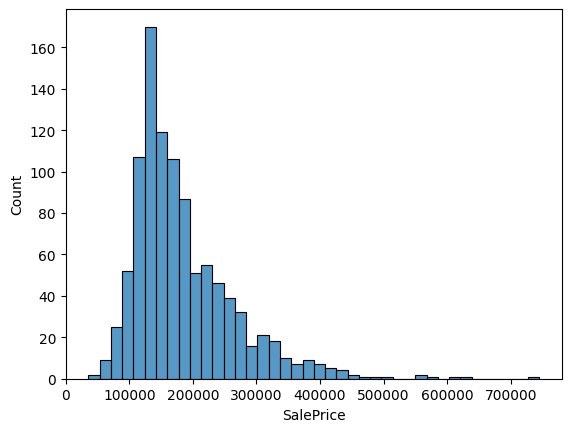

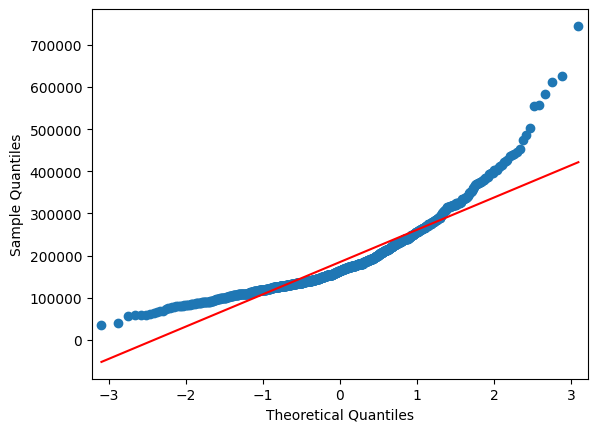

In [93]:
NormalityTest(train['SalePrice'])

ShapiroResult(statistic=0.9887751936912537, pvalue=5.683531298927846e-07)


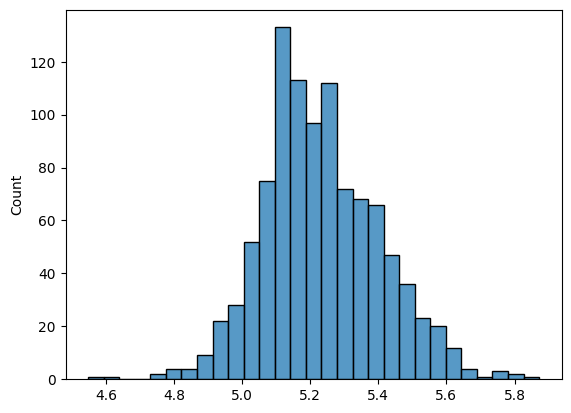

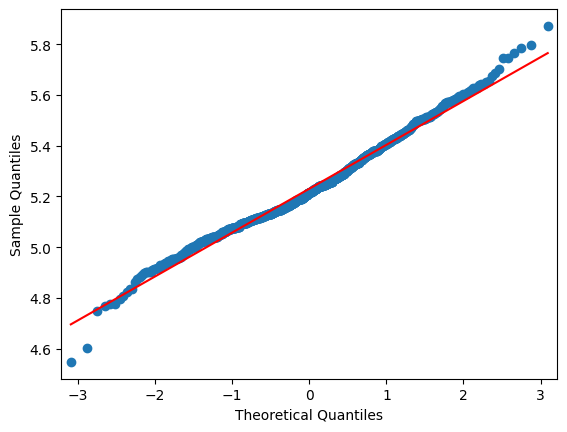

In [94]:
# Normality for log transformed plot 
SalesPrice_trans = pd.Series([np.log(x)/np.log(10) for x in train['SalePrice']])
NormalityTest(SalesPrice_trans)

In [19]:
# Apply log transformation 
train['SalePrice'] = [np.log(x)/np.log(10) for x in train['SalePrice']]
test['SalePrice'] = [np.log(x)/np.log(10) for x in test['SalePrice']]

### Relationship between Sale Prices and features

Next we investigate the relationship between sale price and features. A plot of numerical features with log sales price indicates linearity in the data. 

From the correlation heatmap, we see correlation greater than 0.5 between  
- YearBuilt, GarageYrBlt and YearRemodAdd, 
- 1stFlrSF, TotalBsmtSF and GarageArea 
- 2ndFlrSF and GrLivArea
- GarageYrBlt and GarageArea

Thus, we keep YearBuilt, 1stFlrSF and 2ndFlrSF and remove all other features in the above list. 


In [7]:
def Subplots(data_set, feature_list, y_variable, subplots_per_row = 4):

    # Calculate the number of rows needed
    num_rows = (len(feature_list) - 1) // subplots_per_row + 1
    
    # Create a figure and axes for the subplots
    fig, axes = plt.subplots(num_rows, subplots_per_row, figsize=(15, 4*num_rows))
    
    # Iterate over factors and create pair plots
    for i, feature in enumerate(feature_list):
        row = i // subplots_per_row
        col = i % subplots_per_row
        sns.scatterplot(data=data_set, x=feature, y=y_variable, ax=axes[row, col])
    
    # Adjust the layout of subplots
    plt.tight_layout()
    
    # Show the pair plots
    plt.show()

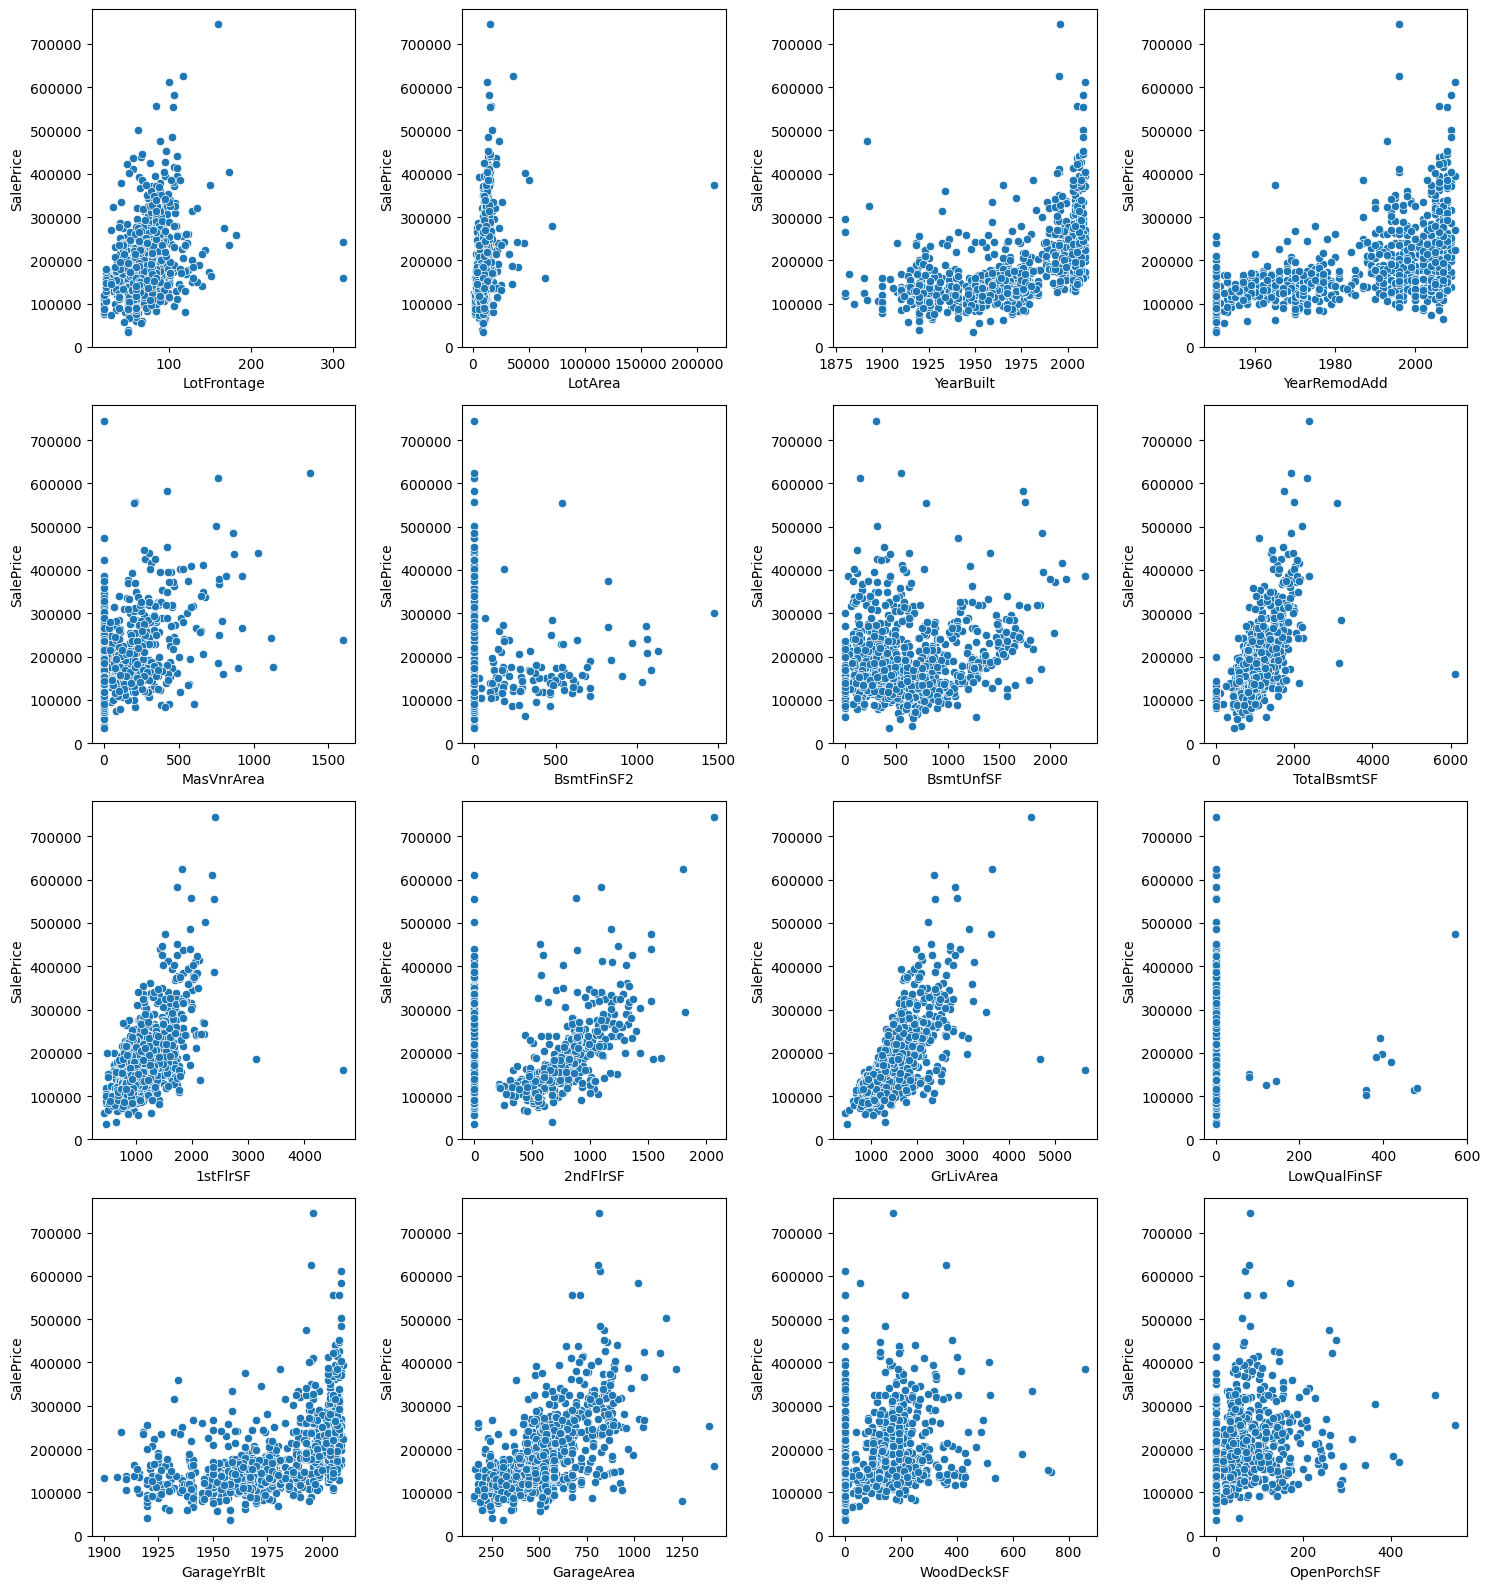

In [8]:
Subplots(train, numerical_subset, 'SalePrice')

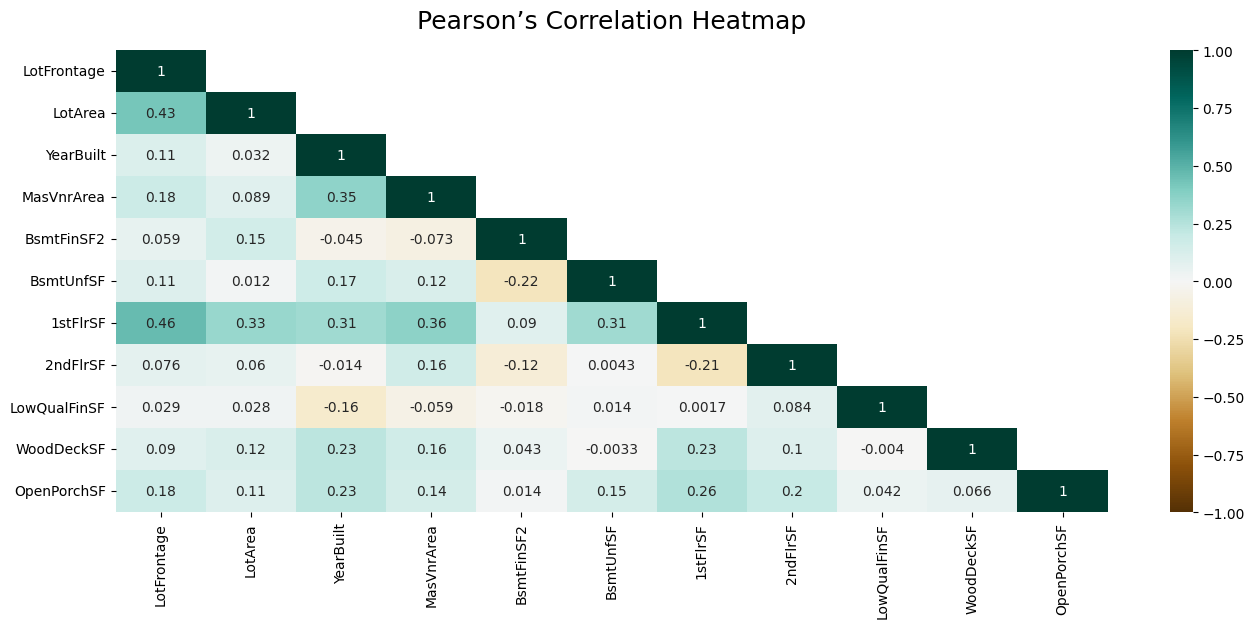

In [33]:
# Extract out numerical variables  
train_num = train.select_dtypes(exclude='category') # exclude categorical variable
num_names = train_num.columns

# Scale 
train_num_scaled = StandardScaler().fit_transform(train_num) # standardise
train_num_scaled = pd.DataFrame(train_num_scaled, columns = num_names)

# Correlation heat map
plt.figure(figsize=(16, 6)) # change size of plot
mask = np.triu(np.ones_like(train_num_scaled.corr(), dtype= bool),1) # define the mask to set the values in the upper triangle to True

# Create correlation heat map
heatmap = sns.heatmap(train_num_scaled.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')

heatmap.set_title('Pearson’s Correlation Heatmap', fontdict={'fontsize':18}, pad=16);


In [21]:
# Drop moderately correlated variables 
train.drop(columns=['GarageYrBlt', 'YearRemodAdd', 'TotalBsmtSF','GarageArea', 'GrLivArea'], inplace=True)
test.drop(columns=['GarageYrBlt', 'YearRemodAdd', 'TotalBsmtSF','GarageArea', 'GrLivArea'], inplace=True)

## Predictor Models

We train several standard machine learning models on the data set. We create prediction models using a variety of techniques including:
- Ordinary Least Squares Lasso regression 
- Random Forest Regression
- Ada Boosted regression
- Nearest neighbors regression 
- Support vector machine 

Categorical variables when included are one-hot encoded into the model. Then a grid search, where model evaluation is done by k-cross validation, is used to tune the hyperparameters of each model. Predictions for each model are finally obtained on the test set and added to a prediction data frame. 

In [22]:
# Response variable for test and training set
y_train = train[['SalePrice']]
y_test = test[['SalePrice']]

# Drop response variable from training and test set
train.drop('SalePrice', axis = 1, inplace = True)
test.drop('SalePrice', axis = 1, inplace = True)

# Data frame for predictions
preds_df = pd.DataFrame()

# Dictionary for number of parameters 
model_params = {}

In [34]:
# Grid Search Function for hyperparameter tuning
def Tune_param(model, trainX, trainy, parameter_grid, splits, scoring_metric = 'neg_mean_squared_error'):
    # model = instance of the model
    # trainX = independent variable training data 
    # trainy = depending variable training data  
    # parameter_grid = set of hyperparameters to be fitted
    # splits = number of k folds 
    
    # Define k-fold cross-validation
    k_fold = KFold(n_splits=splits, shuffle=True, random_state=42)
    
    # Define grid search
    grid_search = GridSearchCV(estimator=model, param_grid=parameter_grid, cv=k_fold, scoring= scoring_metric, verbose=1)
    
    # Perform GridSearchCV
    grid_search.fit(trainX, trainy)
    
    # Print the best parameters and the best score
    print("Best Parameters found: ", grid_search.best_params_)
    print("Best RMSE score found: ", np.sqrt(-grid_search.best_score_))

#### Ordinary Least Squares Regression

The first model we fit is an ordinary least squares lasso regression model. These will be applied to all the numerical features in the data set, with lasso acting as the variable selector. 

The features with a nonzero coefficient are summarised in the following table.

| Features    | Coefficient |
| -------- | ------- |
| LotArea | 0.000005 |
| YearBuilt| 0.002585 |
| BsmtUnfSF| 0.000055 |
| 2ndFlrSF | 0.000102 |
| WoodDeckSF | 0.000176 |

From the residual plots below, we see that the residual are normally distributed and homoscedasticity across the fitted values. 

In [24]:
# Obtain numerical features
X_train = train.select_dtypes(exclude='category')
X_test = test.select_dtypes(exclude='category')

# Add constant variable
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

In [32]:
# Fit model 
ols_model = sm.OLS(y_train, X_train).fit_regularized(method='elastic_net', alpha = 1, L1_wt = 1)

# Predict on test set 
y_pred = ols_model.predict(X_test)

# Summarise coefficients
print(ols_model.params)

# Add predictions to predictions data frame 
model_name = 'OLS_Lasso'
preds_df[model_name] = y_pred
model_params[model_name] = len([p for p in ols_model.params if abs(p)>0.000001])

const           0.000000
LotFrontage     0.000000
LotArea         0.000005
YearBuilt       0.002585
MasVnrArea      0.000000
BsmtFinSF2      0.000000
BsmtUnfSF       0.000055
1stFlrSF        0.000000
2ndFlrSF        0.000102
LowQualFinSF    0.000000
WoodDeckSF      0.000176
OpenPorchSF     0.000000
dtype: float64


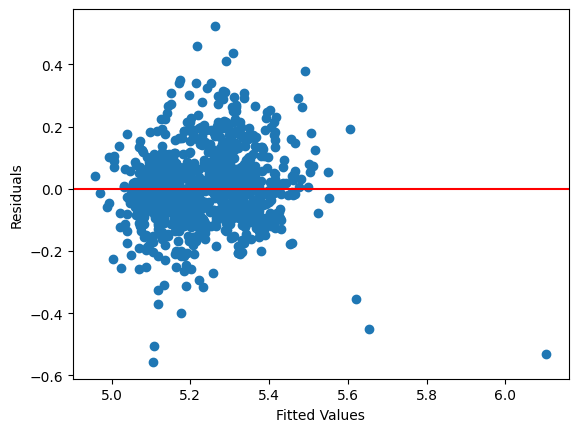

In [26]:
# Calculate residuals 
resid = y_train['SalePrice'] - ols_model.fittedvalues

# Perform White test for heteroscedasticity
#white_test = ssd.het_white(resid, ols_model.model.exog)

# define labels for White test output
#labels = ['Test Statistic', 'Test Statistics p-value', 'F-Statistics', 'F-test p-value']

# print results 
#print(dict(zip(labels,white_test)))

# Residual plot
plt.scatter(ols_model.fittedvalues, resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.axhline(y=0,color = 'r')
plt.show()

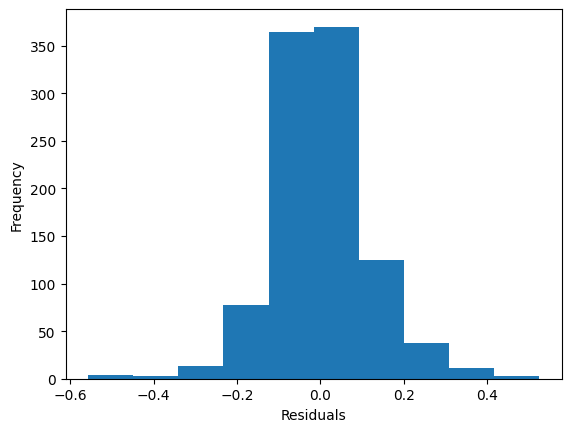

In [28]:
# Histogram of residuals 
plt.hist(resid)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

### Random Forest

In [200]:
# One hot encoder 
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res) 

# Copy all features 
data = X.copy()

for feature in categorical_subset:
    data = encode_and_bind(data, feature)

# Partion data according to train and test split in the previous section 
X_train = data.loc[list(train.index)]
X_test = data.loc[list(test.index)]

In [134]:
# Initialise model
RF = RandomForestRegressor(random_state = 42)

# Define the parameter grid to search over
param_grid = {
    'n_estimators': np.arange(600,750,50),
    'max_depth': np.arange(25,35,1),
    'min_samples_split': [2],
    'min_samples_leaf': [2],
    'max_features': ['sqrt']
}

# Call Grid Search function
Tune_param(RF, X_train, y_train['SalePrice'].ravel(), param_grid, 10)


Fitting 10 folds for each of 30 candidates, totalling 300 fits
Best Parameters found:  {'max_depth': 25, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 700}
Best RMSE score found:  0.07143463220187538


In [201]:
# Initialise random forest regressor with best hyperparameters
RF = RandomForestRegressor(random_state = 42, n_estimators = 700, max_depth = 25, max_features = 'sqrt', min_samples_leaf = 2, min_samples_split = 2)

# Train model on training data
RF.fit(X_train, y_train['SalePrice'].ravel())

# Use the forest's prediction method on the test data
y_pred = RF.predict(X_test)

# Add predictions to predictions data frame 
model_name = 'Random Forest'
preds_df[model_name] = y_pred
model_params[model_name] = RF.n_features_in_

### Gradient Boosted Trees

We apply the XGBoost regression. 

In [202]:
# Initialise model
GBR = GradientBoostingRegressor(random_state = 42)

# Define the parameter grid to search over
param_grid = {
    'n_estimators': np.arange(26,30,1),
    'subsample': np.arange(0.6, 0.8, 0.1),
    'max_depth': np.arange(90,110,10),
    'learning_rate': np.arange(0.28, 0.32, 0.01)
}

# Call Grid Search function
Tune_param(GBR, X_train, y_train['SalePrice'].ravel(), param_grid, 10)


Fitting 10 folds for each of 96 candidates, totalling 960 fits


KeyboardInterrupt: 

In [203]:
# Initalise model with optimised parameter
GBR = GradientBoostingRegressor(random_state = 42, learning_rate = 0.3, max_depth = 90, n_estimators = 27, subsample = 0.7)

# Train using default parameters 
GBR.fit(X_train,y_train['SalePrice'].ravel())

# Predict
y_pred = GBR.predict(X_test)

# Append predictions to data frame
model_name = 'Random Forest'
preds_df[model_name] = y_pred
model_params[model_name] = GBR.n_features_in_


### Ada Boost Regressor

In [138]:
# Initialise model
ADA = AdaBoostRegressor(random_state = 42)

# Define the parameter grid to search over
param_grid = {
    'n_estimators': np.arange(100,300,50),
    'learning_rate': np.arange(0.001,1.0,0.25)
}

# Call Grid Search function
Tune_param(ADA, X_train, y_train['SalePrice'].ravel(), param_grid, 10)


Fitting 10 folds for each of 16 candidates, totalling 160 fits
Best Parameters found:  {'learning_rate': 0.751, 'n_estimators': 250}
Best RMSE score found:  0.07788889776138595


In [204]:
# Initalise model with optimised parameter
ADA = AdaBoostRegressor(random_state = 42, learning_rate = 0.751, n_estimators = 250)

# Fit
ADA.fit(X_train,y_train['SalePrice'].ravel())

# Predict
y_pred = ADA.predict(X_test)

# Append predictions to data frame
model_name = 'Ada Boost Regression'
preds_df[model_name] = y_pred
model_params[model_name] = ADA.n_features_in_

### Nearest Neighbors Regression

In [140]:
# Initialise model
NN_regr = KNeighborsRegressor()

# Define the parameter grid to search over
param_grid = {
    'n_neighbors': np.arange(1,10,1)
}

# Call Grid Search function
Tune_param(NN_regr, X_train, y_train['SalePrice'].ravel(), param_grid, 10)


Fitting 10 folds for each of 9 candidates, totalling 90 fits
Best Parameters found:  {'n_neighbors': 7}
Best RMSE score found:  0.09865977158625165


In [205]:
# Initalise model with optimised parameter
NN_regr = KNeighborsRegressor(n_neighbors = 7)

# Fit
NN_regr.fit(X_train,y_train['SalePrice'].ravel())

# Predict
y_pred = NN_regr.predict(X_test)

# Append predictions to data frame
model_name = 'Nearest Neighbors Regression'
preds_df[model_name] = y_pred
model_params[model_name] = NN_regr.n_features_in_

### Support Vector Machine Rergession

In [206]:
# Standard scaler
from sklearn.preprocessing import StandardScaler

# Define standard scaler
Yscale = StandardScaler()
Xscale = StandardScaler()

y_train_scaled = Yscale.fit_transform(y_train.values) 
y_test_sacled = Yscale.transform(y_test.values)

# Copy data
X_train_scaled = deepcopy(X_train)
X_test_scaled = deepcopy(X_test)

# Scale each numerical feature 
for num_feature in numerical_subset:
    X_train_scaled[num_feature] = Xscale.fit_transform(X_train_scaled[[num_feature]])
    X_test_scaled[num_feature] = Xscale.transform(X_test_scaled[[num_feature]])


In [143]:
# Initalise model
SVR_Poly = SVR()

# Define the parameter grid to search over
param_grid = {
    'kernel': ['poly','rbf'],
    'C': [2**(i) for i in range(-6,6,2)],
    'epsilon':[2**(i) for i in range(-6,6,2)],
}

# Tune parameters
Tune_param(SVR_Poly, X_train_scaled, y_train_scaled.ravel(), param_grid, 10)


Fitting 10 folds for each of 72 candidates, totalling 720 fits
Best Parameters found:  {'C': 4, 'epsilon': 0.015625, 'kernel': 'rbf'}
Best RMSE score found:  0.3253825862888892


In [207]:
# Initalise model with optimised parameter
SVR_Poly = SVR(C = 4, epsilon = 0.015625, kernel = 'rbf')

# fit
SVR_Poly.fit(X_train_scaled, y_train_scaled.ravel())

# Predict
y_pred = SVR_Poly.predict(X_test_scaled)
y_pred = pd.DataFrame(data = y_pred, columns = ['y'])
y_pred = Yscale.inverse_transform(y_pred)

# Append predictions to data frame
model_name = 'Support Vector Machine Regression'
preds_df[model_name] = y_pred
model_params[model_name] = SVR_Poly.n_features_in_

## Model Evaluation

Finally, we evaluate our models using a method by Zhan-Liu-Wu-Zhao-Chow. In the method, 13 metrics were used to evaluate the performance of each model. The models are then ranked for each metric from which an average rank is calculated. Using the Friedman and Iman-Davenpor statistic on the average rank is used to determine whether there is significant difference in performance between the models. 

 Both the Friedman and Iman-Davenpor statistics support the null hypothesis that the performance between models are non-significant. Regadless, on the mean performance rank, we have the following rankings:
 Model Rankings: 
1. OLS_Lasso
2. Nearest Neighbors Regression
3. Ada Boost Regression
4. Random Forest
5. Support Vector Machine Regression

Plotting the true values against the predicted value of the best two and worst performing models, we see that models underestimate the true value for sales price with a large value ($log (sales) > 5.6$). Once again, the tests show non-significance in performance, thus we can conclude that any of the models above could be chosen. 

In [208]:
# === Evaluation Metrics === #

def Evalutaion_Score(y_pred, y_valid, model_name, num_param):
# Outputs pandas data frame of evaluation scores. 

    ## == Parameters == ##
    alpha = 0.5; # Pinball loss parameter
    k = num_param;  # Number of parameters in the model 
    m = len(y_pred); # Number of predictions 

    
    ## === Calculte Evaluation Metrics == ##
    # Preliminary calculations
    y_err = [x-y for x,y in zip(y_pred,y_valid)];
    y_valid_avg = [np.mean(y_valid) for i in y_valid.index];
    
    # Mean square error
    mse = np.mean([y_d**2 for y_d in y_err]);

    # Root Mean square error
    rmse = mse**(1/2);

    # Mean absolute error 
    mae = np.mean([abs(y_d) for y_d in y_err]);

    # Rsquared (Explained error/Total error)
    rsquare = 1 - m*mse/(sum([(y-y_bar)**2 for y, y_bar in zip(y_valid,y_valid_avg)]));  

    # Adjusted R-Square
    r_adj = 1 - ((1-rsquare)*(m-1))/(m-k-1);

    # Median absolute deviation
    med = np.median(y_err);
    mad = np.mean([abs(y_d-med) for y_d in y_err]);

    # Mean Absolute Percentage Error
    mape = np.mean([abs(y_d/y) for y_d, y in zip(y_err, y_valid)]);
    
    # Root Mean Square Logarithmic Error
    y_pred_log = [np.log(1+ y) for y in y_pred];
    y_valid_log = [np.log(1+ y) for y in y_valid];
    rmsle = (np.mean([(y1-y2)**2 for y1, y2 in zip(y_pred_log,y_valid_log)]))**(1/2);

    # Explained Varience Score
    evs = 1 - np.var(y_err)/np.var(y_valid);

    # Max Error
    me = max([abs(y_d) for y_d in y_err]);
    
    # Mean Poisson Deviance 
    mpd = np.mean([y_valid[i]*np.log(y_valid[i]/y_pred[i])+ y_pred[i] - y_valid[i] for i in y_valid.index]);
        
    # Mean Gamma Deviance 
    mgd = np.mean([y_valid[i]*np.log(y_valid[i]/y_pred[i])+ y_pred[i] - y_valid[i] for i in y_valid.index]);
    
    # Pinball Loss
    pl = np.mean([alpha*max([-y,0])+(1-alpha)*max([y,0]) for y in y_err]);

    
    ## == output == ##
    
    data = {
        'Model_Name': model_name,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'RSquare': rsquare,
        'AdjRSquare': r_adj,
        'MAD': mad,
        'MAPE': mape,
        'RMSLE': rmsle,
        'EVS': evs,
        'ME': me,
        'MPD': mpd,
        'MGD': mgd,
        'PL': pl
    }
    
    df = pd.DataFrame.from_dict([data]);

    return df 


# === Evaluation === #

def Evaluate(pred_df, y_valid, model_params):
    ## Outputs a dictionary containing
    # 1. 'Ranking': a pandas data frame of the ranking of all the models based on the metrics.  
    # 2. ('Friedman statistic', p-value, reject/accept H_0) 
    # 3. ('Iman Davenport statistic', p-value, reject/accept H_0)
    # where H_0 tests that all model performances are non-significant 
    ## Inputs 
    # pred_df: pandas data frame with predictions over rows and models over columns. 
    # y_valid: list of predictions with same order as rows in pred_df.
    # model_params: A dictionary with models as keys and number of parameters in model as values. 
    
    # Initialise parameters
    k = pred_df.shape[1];
    d = 13; # Number of evaluation metrics

    ### Step 1: calculate rankings based on metrics ###
    
    # Create a data frame containing evaluation metrics (y axis) for each model (x axis)
    df = pd.DataFrame(columns = ['Model_Name','MSE', 'RMSE','MAE','RSquare','AdjRSquare','MAD','MAPE','RMSLE','EVS','ME','MPD','MGD','PL']);
    
    for model in pred_df.columns:
        # Extract our predictions and evaluate 
        y_pred = pred_df[model];
        df = pd.concat([df, Evalutaion_Score(y_pred, y_valid, model, model_params[model])],ignore_index = True);
    
    # Create a data frame of ranks for each evaluation metric
    for metric in df.columns[1:]:
        df[metric] = df[metric].rank(ascending = False);

    # Calculate the mean ranking for each model 
    df['mean'] = (df.loc[:, df.columns != 'Model_Name']).mean(axis = 'columns')

    ### Step 2: Perform statistical evaluation ###

    # Calculate Test value
    T_F = ((12*d)/(d*(d+1))) * sum([(R_mu - (k+1)/2)**2 for R_mu in df['mean']]);
    T_ID = ((d-1)*T_F)/(d*(k-1)-T_F);

    # Calculate Distribution value
    p_F = chi2.isf(0.05,k-1)
    p_ID = f.isf(0.05,k-1,(k-1)*(d-1))

    #  Conclude Hypothesis Test
    F_hypothesis, ID_hypothesis = 'Accept', 'Accept'
    
    if T_F > p_F:
        F_hypothesis = 'Reject'

    if T_ID > p_ID:
        ID_hypothesis = 'Reject'

    ### Step 3: Nemenyi Post-Hoc ### 

    return {
        'Ranking': df,
        'Friedman': [T_F, p_F, F_hypothesis],
        'Iman–Davenpor': [T_F, p_ID, ID_hypothesis]
    }

def Nemenyi(Rankings_df):
    # Calculate the critical distance
    q = 1
    CD = q (k*(k+1)/(6*d)) ** (1/2)
    

In [209]:
result = Evaluate(preds_df, y_test['SalePrice'], model_params)

print(result['Ranking'])
print(result['Friedman'])
print(result['Iman–Davenpor'])

                          Model_Name  MSE  RMSE  MAE  RSquare  AdjRSquare  \
0                          OLS_Lasso  1.0   1.0  1.0      5.0         5.0   
1                      Random Forest  4.0   4.0  4.0      2.0         3.0   
2               Ada Boost Regression  3.0   3.0  3.0      3.0         2.0   
3       Nearest Neighbors Regression  2.0   2.0  2.0      4.0         1.0   
4  Support Vector Machine Regression  5.0   5.0  5.0      1.0         4.0   

   MAD  MAPE  RMSLE  EVS   ME  MPD  MGD   PL      mean  
0  1.0   1.0    1.0  5.0  2.0  1.0  1.0  1.0  2.000000  
1  4.0   4.0    4.0  2.0  4.0  4.0  4.0  4.0  3.615385  
2  3.0   3.0    3.0  3.0  3.0  3.0  3.0  3.0  2.923077  
3  2.0   2.0    2.0  4.0  1.0  2.0  2.0  2.0  2.153846  
4  5.0   5.0    5.0  1.0  5.0  5.0  5.0  5.0  4.307692  
[3.2662721893491122, 9.487729036781158, 'Accept']
[3.2662721893491122, 2.5652405084790386, 'Accept']


/var/folders/5p/jyr0hpzn3md4y89p3c900rx40000gp/T/ipykernel_4264/786334851.py:109: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, Evalutaion_Score(y_pred, y_valid, model, model_params[model])],ignore_index = True);


In [210]:
print("Model Rankings: ")
print(result['Ranking'].sort_values(by = ['mean'])['Model_Name'])

Model Rankings: 
0                            OLS_Lasso
3         Nearest Neighbors Regression
2                 Ada Boost Regression
1                        Random Forest
4    Support Vector Machine Regression
Name: Model_Name, dtype: object


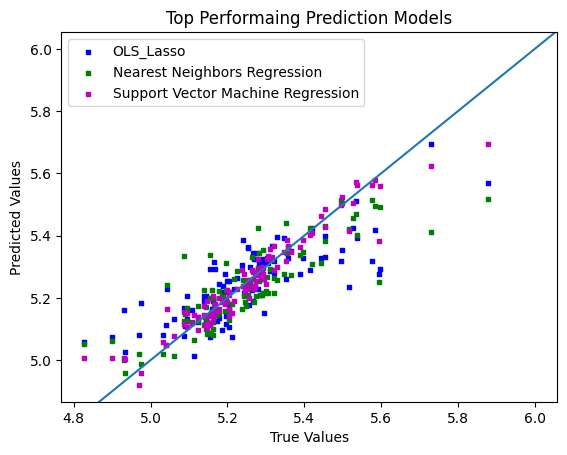

In [213]:
# Extract out names of best 2 and worst model 
model_names_4plot = [result['Ranking'].sort_values(by = ['mean'])['Model_Name'].iloc[i] for i in [0,1,-1]]

# Add true values to the predictions data frame
final_plots_data = preds_df[model_names_4plot].join(y_test)

# Create plot
fig = plt.figure()
ax1 = fig.add_subplot(111)

# Create plot of true values vs predicted values
x = final_plots_data[final_plots_data.columns[-1]]

for name, color in zip(model_names_4plot,['b','g','m']):
    ax1.scatter(x, final_plots_data[name], s=10, c=color, marker="s", label=name)

# Plot line where true values = predicted values
ax1.axline((6, 6), slope=1)

plt.title('Top Performaing Prediction Models')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend(loc='upper left')
plt.show()